## Initialise Notebook

In [1]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\ode-biomarker-project


In [2]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# Plotting 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set_context("talk")

c:\Github\ode-biomarker-project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Bring in CCLE data
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

In [4]:
# attempt load from loading code

loading_code = 'fgfr4_model_raw_simulation'
simulation_data = data_link.get_data_from_code(loading_code)

In [5]:
loading_code = 'fgfr4_ccle_dynamic_features'
dynamic_features = data_link.get_data_from_code(loading_code)

## Analysis Chain

In [6]:
### OPTIONS

target_protein = "pAkt"
folder_name = "testFolder"
fixed_random_seed = 42 # -1 for no seed

if not os.path.exists(f'{path_loader.get_data_path()}data/results/{folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{folder_name}')

file_save_path = f'{path_loader.get_data_path()}data/results/{folder_name}/'

c:\Github\ode-biomarker-project\venv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


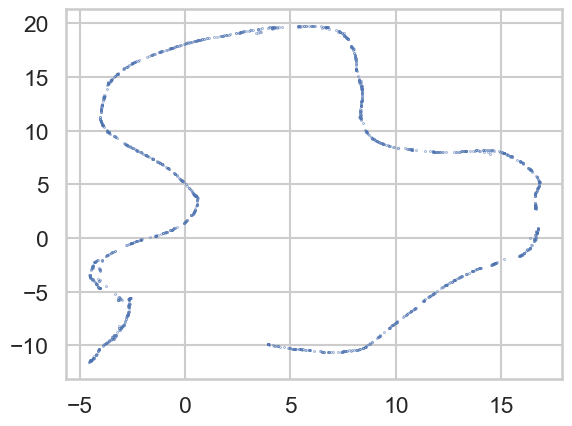

In [7]:
indexed_dyn_feats = dynamic_features.set_index('Row')
target_dynamic_features = indexed_dyn_feats.filter(like=target_protein, axis=1)

dyn_feat_cols = ['auc', 'median', 'tfc', 'tmax', 'max', 'tmin', 'min', 'ttsv', 'tsv', 'init']
joint_dyn_feat_data = []
for row in range(target_dynamic_features.shape[0]):
    ptp_data = target_dynamic_features.iloc[row].tolist()
    joint_dyn_feat_data.append(ptp_data)
    
joint_dynamic_features = pd.DataFrame(joint_dyn_feat_data, columns=dyn_feat_cols)

standard_embedding = umap.UMAP(random_state=fixed_random_seed).fit_transform(joint_dynamic_features)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1)

c:\Github\ode-biomarker-project\venv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


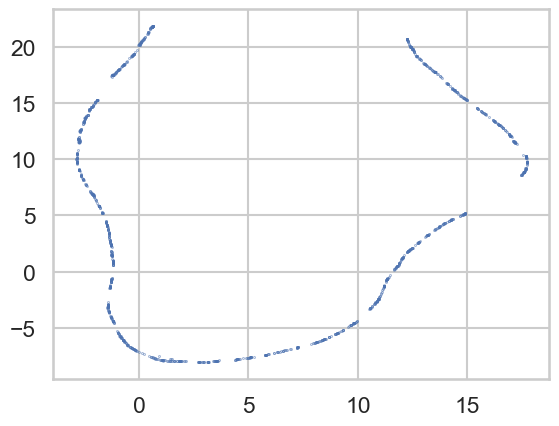

In [8]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=fixed_random_seed,
).fit_transform(joint_dynamic_features)

plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1)

labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)

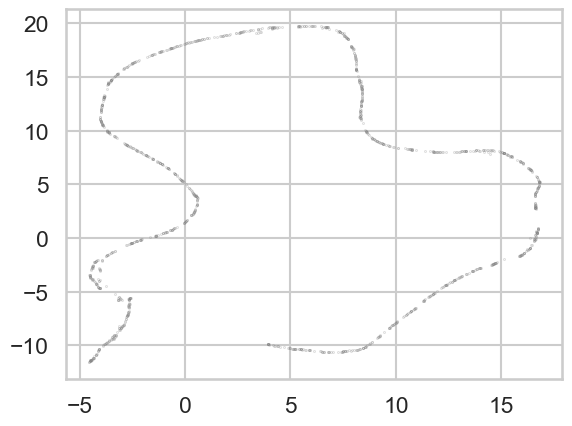

In [9]:
clustered = (labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral')

In [10]:
np.sum(clustered) / joint_dynamic_features.shape[0]

0.0

In [11]:
all_celllines = simulation_data['Cellline'].unique()
all_proteins = simulation_data.columns[2:]

protein_df_data = []

count = 0
for cellline in all_celllines:
    for protein in all_proteins:
        if protein == 'pAkt':
            cellline_protein_data = simulation_data[(simulation_data['Cellline'] == cellline)]
            protein_data = cellline_protein_data[protein]
            protein_df_data.append(protein_data.tolist())

time_column_df = pd.DataFrame(protein_df_data, columns=cellline_protein_data['Time'])

<AxesSubplot: xlabel='Time'>

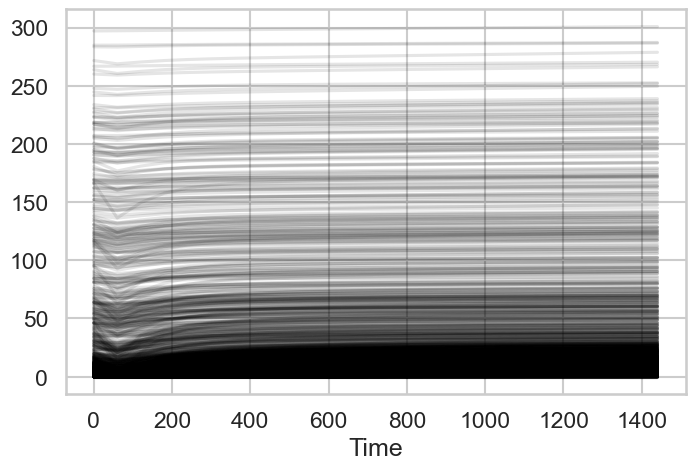

In [15]:
# plot time column df 

time_column_df = time_column_df.T
time_column_df.plot(legend=False, alpha=0.1, color='black', figsize=(8, 5))